In [ ]:
# Import necessary libraries
# The script uses transcriptomics datasets imported through GRATIOSA
# https://github.com/sammeyer2017/GRATIOSA
#%load_ext autoreload
#%autoreload 2
import sys,os
import numpy as np
import pandas as pd
from scipy import interpolate
from scipy.integrate import trapz
import matplotlib.pyplot as plt
import matplotlib.lines as lines
from GRATIOSA import Genome, Chipseq, Transcriptome, GO 
from GRATIOSA import stat_analysis, plot_stat_analysis, useful_functions_Chipseq
from GRATIOSA.globvar import *
from scipy import stats
from scipy.stats import spearmanr
cm = 1/2.54  # centimeters in inches

In [ ]:
# Create dictionaries with all analyzed conditions

In [2]:
organisms = ["D. dadantii", "E. coli", "S. enterica", "S. enterica_", "S. pneumoniae", "M. pneumoniae", "S. elongatus"]
# tags
organism_tags_v = ["dickeya","ecoli","salmonella_RNAseq","salmonella","streptococcus","mycoplasma_pneu","synechococcus"]
organism_tags = {organisms[i]: organism_tags_v[i] for i in range(len(organisms))}
# expression tag for each 
expression_tags_v = ["wt_Expo", "base", "basemean", "base", "base", "base", "base"]
expression_tags = {organisms[i]: expression_tags_v[i] for i in range(len(organisms))}
# conditions
conditions = {}
conditions_tags = {}
# Dickeya
# Data sources: https://academic.oup.com/nar/article/47/11/5648/5477453, https://academic.oup.com/nar/article/50/16/9149/6660960
conditions["D. dadantii"] = ["novo_expo", "seco_expo"]
conditions_tags["D. dadantii"] = ["WT_nov_expo_vs_WT_expo", "WT+seco/WT"]
# E. coli
# Data sources: https://www.embopress.org/doi/full/10.1038/sj.embor.7400729, https://link.springer.com/article/10.1186/gb-2004-5-11-r87
conditions["E. coli"] = ["novo_Blot", "novo_Peter_100"]
conditions_tags["E. coli"] = ["Blot", "Peter_200"]
# S. enterica
# Data source: https://www.sciencedirect.com/science/article/pii/S2352340920301918
conditions["S. enterica"] = ["novo_500_60min"]
conditions_tags["S. enterica"] = ["Novo500_60min"]
# S. pneumoniae
# Data source: https://academic.oup.com/nar/article/38/11/3570/3100681, https://academic.oup.com/nar/article/44/15/7292/2457757
conditions["S. pneumoniae"] = ["novo_5min", "novo_15min", "novo_30min", "seco_5min", "seco_15min", "seco_30min", "seco_5min_rnaseq", "seco_15min_rnaseq"]
conditions_tags["S. pneumoniae"] = ["novo5", "novo15", "novo30", "secot5", "secot15", "secot30", "secot5_rnaseq", "secot15_rnaseq"]
# M. pneumoniae
# Data source: https://www.cell.com/cell-systems/fulltext/S2405-4712(16)30149-1
conditions["M. pneumoniae"] = ["novo_50"]
conditions_tags["M. pneumoniae"] = ["nov50"]
# S. elongatus
# Data source: https://www.pnas.org/doi/abs/10.1073/pnas.0912673106
conditions["S. elongatus"] = ["corr_sc"]
conditions_tags["S. elongatus"] = ["corr_supercoil"]

In [3]:
#test_organisms=["S. enterica_"]
test_organisms=organisms

In [ ]:
# Create violin plot with quartiles for all datasets
# Create a file with correlation tests for all datasets
corf=open("correl_values_expr_log2FC_select.txt","w")
corf.write("Species\tCondition\tNumber of genes\tCorrelation coefficient\tP-value\n")
for org in test_organisms: 
    #os.makedirs(org)
    # Load the organism data
    print("----------------------")
    print(org, organism_tags[org])
    g = Genome.Genome(organism_tags[org])
    g.load_seq()
    if org=="D. dadantii":
        g.load_annotation(features=["CDS"])
    #elif org=="S. elongatus":
    #    g.load_annotation(annot_file="annotation.info")
    else:
        g.load_annotation()
    tr=Transcriptome.Transcriptome(g)
    tr.load_expression()
    tr.load_fc_pval()
    tr.compute_state_from_fc()
    # Classify genes by expression
    classif_genes = stat_analysis.data_classification(
    data_x = tr.genes_valid_expr[expression_tags[org]].keys(),
    data_y = [tr.genes[x].expression[expression_tags[org]] for x in tr.genes_valid_expr[expression_tags[org]].keys()],
    class_nb = 4)
    ### T-TEST OF log2FC average values
    # For each fold-change condition, create the dictionary of fold-change values
    # Violin plot for log2FC of genes split into quartiles
    for ic, cond in enumerate(conditions_tags[org]):
        dict_cond={}
        number_genes=0
        for expr_class in range(4):
            dict_cond[expr_class]=[tr.genes[x].fc_pval[cond][0] for x in tr.genes_valid_fc[cond] if x in classif_genes[0][expr_class]]
            number_genes+=len(dict_cond[expr_class])
        plot_stat_analysis.plot_student_test(dict_cond, method = "wilcoxon", alt_hyp = "two-sided", output_dir = "%s/"%org, output_file= "fc_quartiles_all_%s_%s"%(org,conditions[org][ic]), xlabel = 'quartile', ylabel = "log2 fold_change", title = "%s, %s, %d genes"%(org,conditions[org][ic],number_genes))
        # violin plot
        fig=plt.figure()
        plt.violinplot([dict_cond[k] for k in dict_cond.keys()],positions=range(1,5),showextrema=False,showmedians=True)
        plt.xticks(range(1,5))
        plt.ylim(-3,3)
        plt.xlabel("quartile")
        plt.savefig("%s/fc_violin_all_%s_%s.pdf"%(org,org,conditions[org][ic]))
    # --------------------------------------------
    # Compute the t-test for SIGNIFICANTLY DIFF EXPR GENES
    # Also compute the correlation test for the file
    # Here we include all genes, independently of their quartile
    for ic, cond in enumerate(conditions_tags[org]):
        dict_cond={}
        number_genes=0
        corf_expr=[]
        corf_log2FC=[]
        for expr_class in range(4):
            dict_cond[expr_class] = [tr.genes[x].fc_pval[cond][0] for x in tr.genes_valid_fc[cond] if x in classif_genes[0][expr_class] and tr.genes[x].fc_pval[cond][1]<0.05]
            corf_log2FC += dict_cond[expr_class]
            corf_expr += [tr.genes[x].expression[expression_tags[org]] for x in tr.genes_valid_fc[cond] if x in classif_genes[0][expr_class] and tr.genes[x].fc_pval[cond][1]<0.05]
            number_genes+=len(dict_cond[expr_class])
        # compute the correlation and write in file
        qq=spearmanr(corf_expr,corf_log2FC)
        corf.write("%s\t%s\t%d\t%.3f\t%.3e\n"%(org,conditions[org][ic],number_genes,qq.correlation,qq.pvalue))
corf.close()

# Plot all correlation coefficients as a Volcano plot and as a simple barplot

In [6]:
cor=pd.read_csv("correl_values_expr_log2FC_select.txt",sep="\t")

In [54]:
def symbol(pv):
    if pv > 0.05: 
        return " -"
    elif pv > 0.01: 
        return " *"
    elif pv > 0.001: 
        return " **"
    #elif pv > 0.0001: 
    #    return "***"
    else: 
        return "***"

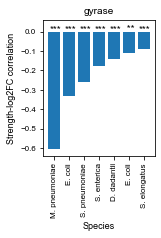

In [82]:
fig=plt.figure(figsize=(2,2.5))
novo=cor.loc[[8,3,6,5,0,2,4]]
plt.bar(np.arange(7),novo["Correlation coefficient"],tick_label=novo["Species"])#,novo["P-value"],marker="o",color="blue",ms=3,ls="")
#plt.bar(np.arange(10,13),seco["Correlation coefficient"],tick_label=seco["Species"])
# Names
for ipv,pv in enumerate(novo["P-value"]):
    plt.text(ipv-.3,0.0,symbol(pv),fontsize=10)
plt.xlabel("Species")
plt.xticks(rotation=90)
plt.title("gyrase")
plt.ylabel("Strength-log2FC correlation")
plt.ylim(-.64,0.06)
#plt.yscale("log")
plt.savefig("correlation_novo.svg")

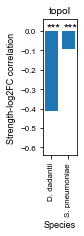

In [88]:
fig=plt.figure(figsize=(.6,2.5))
seco=cor.loc[[1,7]]
#plt.plot(seco["Correlation coefficient"],seco["P-value"],marker="o",color="red",ms=3,ls="")
# Novo
#novo=cor.loc[[0,1,4,5,6,7,8,10]]
novo=cor.loc[[10,5,8,7,0,4,6,1]]
#plt.bar(np.arange(8),novo["Correlation coefficient"],tick_label=novo["Species"])#,novo["P-value"],marker="o",color="blue",ms=3,ls="")
plt.bar(np.arange(2),seco["Correlation coefficient"],tick_label=seco["Species"])
# Names
for ipv,pv in enumerate(seco["P-value"]):
    plt.text(ipv-.3,0.0,symbol(pv),fontsize=12)
plt.xlabel("Species")
plt.xticks(rotation=90)
plt.title("topoI")
plt.ylabel("Strength-log2FC correlation")
plt.ylim(-.64,0.06)
#plt.yscale("log")
plt.savefig("correlation_seco.svg")